# Imports

In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn model selection and metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Scikit-learn transformers and preprocessors & Feature Selection
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import make_pipeline

# Scikit-learn regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# External regressor
import xgboost as xgb

# Miscellaneous settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
houses = pd.read_csv('https://raw.githubusercontent.com/MerleSt/HousingPricePrediction/main/Data/housing_prices.csv')

In [3]:
houses.drop(columns=['Id'], inplace=True)

## Outliers

# Split Data

In [4]:
X = houses.copy()
y = X.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Temporarily set the display options to show all rows
pd.set_option('display.max_rows', None)

# Display the NaN counts for all columns
print(X_train.isna().sum())

# Reset the display options back to default settings
pd.reset_option('display.max_rows')

MSSubClass          0
MSZoning            0
LotFrontage       217
LotArea             0
Street              0
Alley            1094
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          6
MasVnrArea          6
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           28
BsmtCond           28
BsmtExposure       28
BsmtFinType1       28
BsmtFinSF1          0
BsmtFinType2       28
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [6]:
# After inspection we find that where there is not fireplace fireplacequ was set to missing instead of 'NA'
X_train.loc[X_train['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'

In [7]:
garage_null_rows = X_train[X_train['GarageCond'].isnull()]

# Display just the garage-related columns for these rows
garage_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
garage_null_rows[garage_columns]

# Let us reset the columns to 'NA'

# List of columns to update
cols_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Set those columns to 'NA' where GarageArea is 0
X_train.loc[X_train['GarageArea'] == 0, cols_to_update] = 'NA'
X_train.loc[X_train['GarageArea'] == 0, 'GarageYrBlt'] = -9999

In [8]:
pool_null_rows = X_train[X_train['PoolQC'].isnull()]

# Display just the pool-related columns for these rows
pool_columns = ['PoolArea', 'PoolQC']
pool_null_rows[pool_columns]

# Just as I thought, let us replace the missing values with 'NA'
X_train.loc[X_train['PoolArea'] == 0, 'PoolQC'] = 'NA'

In [9]:
# Let us check the Fence
X_train[X_train['Fence'] == 'NA']
X_train['Fence'].fillna('NA', inplace=True)

In [10]:
# MiscFeature
X_train[X_train['MiscFeature'] == 'NA']
X_train['MiscFeature'].fillna('NA', inplace=True)

In [11]:
# Alley
X_train[X_train['Alley'] == 'NA']
X_train['Alley'].fillna('NA', inplace=True)

In [12]:
# Doesnt work for LotFrontage so it will be needed to use SimpleImputer

In [13]:
# Electrical we dont know, so since it is only one observation

In [14]:
# All Basement Columns
no_basement_rows = X_train[X_train['TotalBsmtSF'] == 0]

# Define the list of basement-related columns
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# Display the values in the basement-related columns for these rows
no_basement_rows[bsmt_columns]

# List of columns to update based on your provided list
bsmt_columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

X_train.loc[X_train['TotalBsmtSF'] == 0, bsmt_columns_to_update] = 'NA'

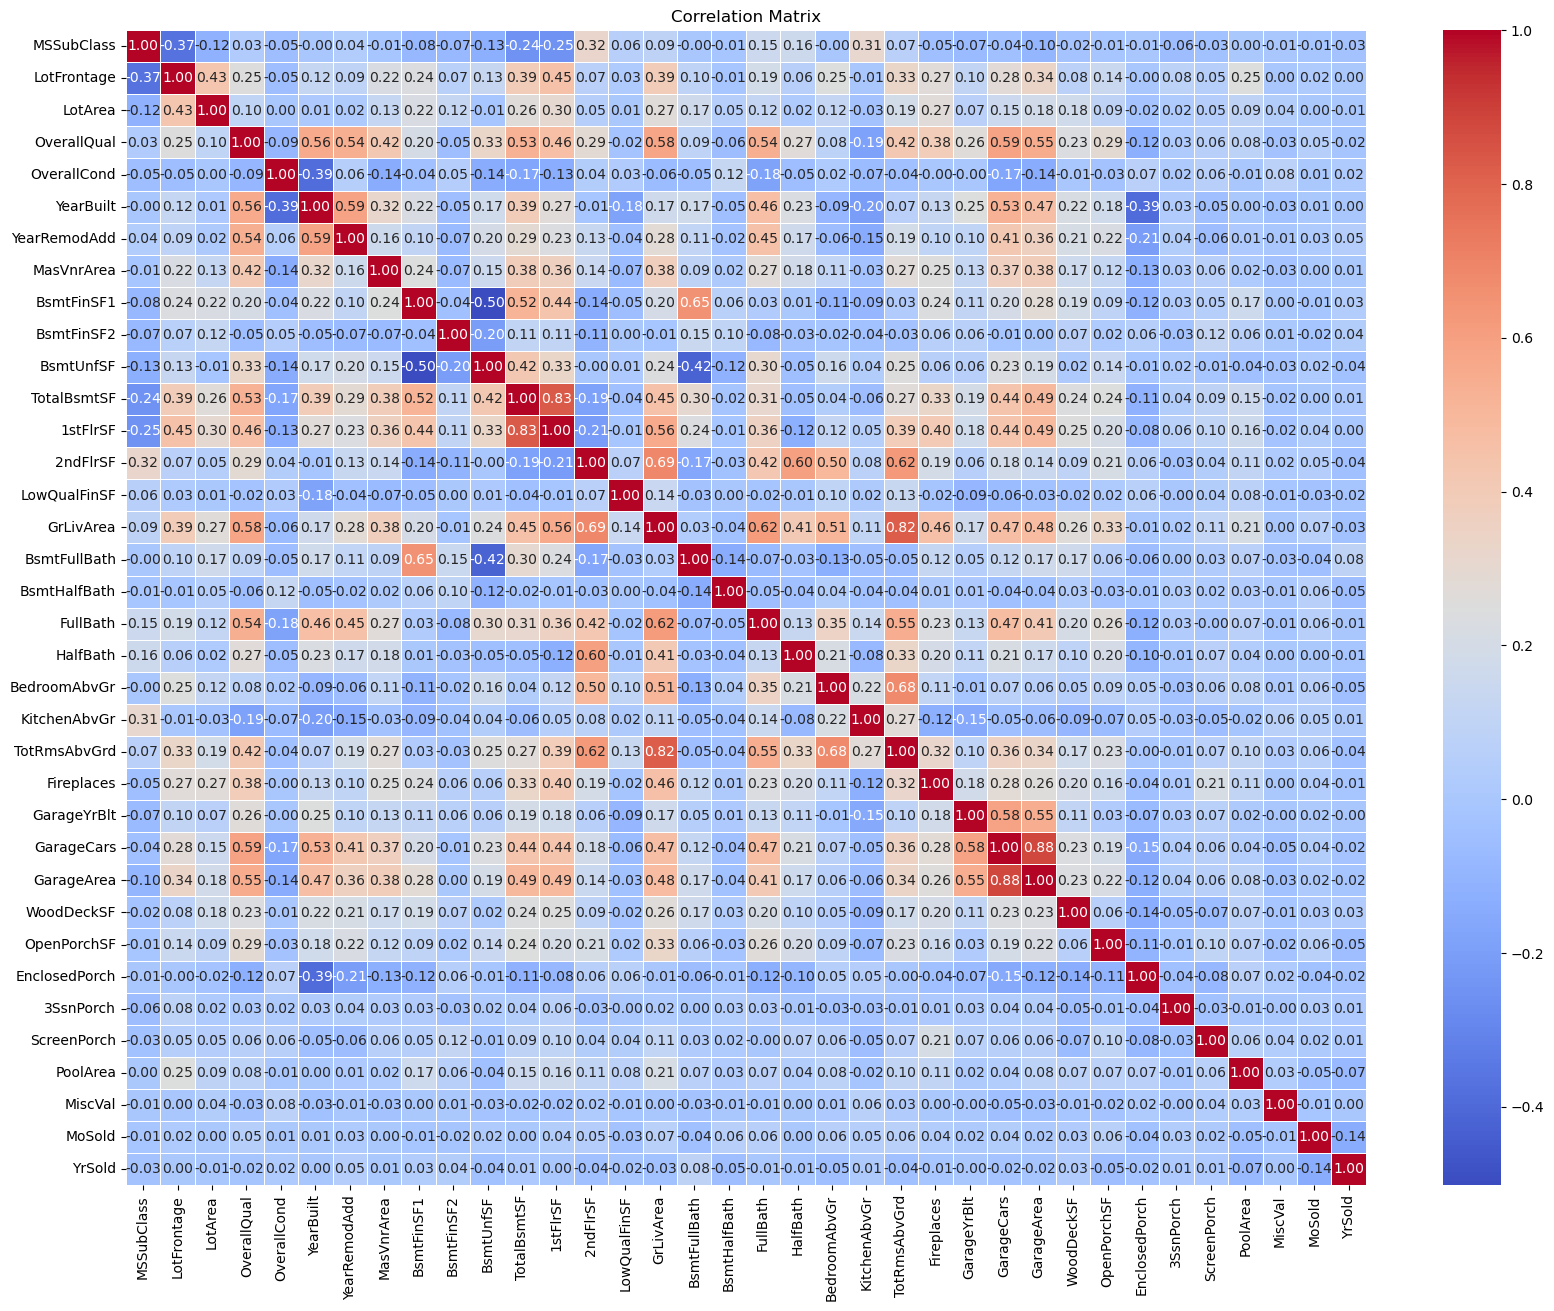


Pairs with high correlation:
Features: 1stFlrSF - TotalBsmtSF, Correlation: 0.83
Features: GrLivArea - TotRmsAbvGrd, Correlation: 0.82
Features: GarageArea - GarageCars, Correlation: 0.88


In [15]:
# Correlation matrix
corr_matrix = X_train.corr()

# Making heatmap larger
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Finding pairs with high correlation
high_corr_pairs = []
for feature1 in corr_matrix.columns:
    for feature2 in corr_matrix.columns:
        # We only consider pairs where feature1 < feature2 to avoid duplicate pairs and self-correlation
        if feature1 < feature2 and (corr_matrix.loc[feature1, feature2] > 0.8 or corr_matrix.loc[feature1, feature2] < -0.8):
            high_corr_pairs.append((feature1, feature2, corr_matrix.loc[feature1, feature2]))

# Print the high correlation pairs
print("\nPairs with high correlation:")
for pair in high_corr_pairs:
    print(f"Features: {pair[0]} - {pair[1]}, Correlation: {pair[2]:.2f}")

# Preprocess Data

 Let us remember the LotFrontage is the only one with missing values.

In [39]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [40]:
# Define orders
order_LandSlope = ['Sev', 'Mod', 'Gtl']
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageFinish = ['NA', 'Unf', 'RFn', 'Fin']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_LandSlope, order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond, 
        order_BsmtExposure, order_BsmtFinType1, order_BsmtFinType2, order_HeatingQC, 
        order_KitchenQual, order_FireplaceQu, order_GarageFinish, order_GarageQual, 
        order_GarageCond, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


In [41]:
cat_ordinal = [
    'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence'
]
cat_onehot = [col for col in cat_features if col not in cat_ordinal]

## Pipelines

### Select From Model

In [42]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median')
)

cat_ordinal_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc
)

cat_onehot_pipe = make_pipeline(
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

In [43]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('onehot', cat_onehot_pipe, cat_onehot),
    ('ordinal', cat_ordinal_pipe, cat_ordinal)
])

In [21]:
pipeline = make_pipeline(preprocessor, SelectFromModel(RandomForestRegressor(random_state=42)), RandomForestRegressor(random_state=42))

In [22]:
print(X_train.shape)  # For features
print(y_train.shape)  # For target

(1168, 79)
(1168,)


In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLi...
                                                  ['LandSlope', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=42))),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [24]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False).round(2)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,17803.55,28101.23,0.110297,0.897048


# Hypertuning

## Randomized Grid Search

In [25]:
param_grid = {
    'selectfrommodel__estimator__n_estimators': range(50,120, 5),
    'selectfrommodel__estimator__max_depth': range(2,40,3),
    'selectfrommodel__estimator__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

}

In [26]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-2
)

In [27]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnin

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['MSSubClass',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'BsmtFinSF1',
                                                                                'BsmtFinSF2',
                                                                                'BsmtUnfSF',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrS...
                                              SelectFromModel(estimator=RandomForestRegressor(random_state=42))),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'selectfrommodel__estimator__criterion': ['squared_error',
                                                                                  'absolute_error',
                                                                                  'friedman_mse',
                                                                                  'poisson'],
                                        'selectfrommodel__estimator__max_depth': range(2, 40, 3),
                                        'selectfrommodel__estimator__n_estimators': range(50, 120, 5)},
                   random_state=42, verbose=1)

In [28]:
search.best_params_

{'selectfrommodel__estimator__n_estimators': 50,
 'selectfrommodel__estimator__max_depth': 11,
 'selectfrommodel__estimator__criterion': 'poisson'}

## Evaluate Model

In [29]:
predictions = search.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,17806.347116,28459.064384,0.108836,0.894409


## Grid Search

In [30]:
param_grid = {
    'selectfrommodel__estimator__n_estimators': range(40,50),
    'selectfrommodel__estimator__max_depth': range(8,14),
    'selectfrommodel__estimator__criterion': ['poisson']

}

In [31]:
search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-2
)

In [32]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=40; total time=   0.7s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=42; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=44; total time=   0.8s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=40; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=42; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=44; total time=   0.8s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=41; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=43; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=45; total time=   0.9s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=43; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=46; total time=   0.9s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=40; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=43; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=49; total time=   0.8s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnin

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=40; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=45; total time=   0.7s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=49; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=41; total time=   0.9s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=41; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=42; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=44; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=42; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=47; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=49; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=44; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=46; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnin

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=46; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=49; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=41; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=44; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=45; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=47; total time=   0.8s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=49; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=47; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=49; total time=   1.0s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=40; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=44; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=48; total time=   1.0s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.war

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=44; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estima

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=49; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estim

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=8, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=49; total time=   0.9s
[CV] END selectfrommodel__estimato

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=40; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=48; total time=   1.0s
[CV] END selectfrommodel__est

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=40; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__esti

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=48; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=46; total time=   1.0s


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnin

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=9, selectfrommodel__estimator__n_estimators=48; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=40; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=44; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__esti

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=44; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=47; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=40; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  war

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=43; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=45; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=47; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=49; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=49; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=41; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=47; total time=   1.1s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.war

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=49; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=46; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=48; total time=   1.2s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=40; total time=   1.1s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=47; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=49; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=43; total time=   1.1s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnin

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=47; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=49; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=44; total time=   1.1s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=42; total time=   0.9s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=10, selectfrommodel__estimator__n_estimators=48; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=40; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=48; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=41; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  wa

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=45; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=47; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=49; total time=   1.2s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=13, selectfrommodel__estimator__n_estimators=41; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=13, selectfrommodel__estimator__n_estimators=43; total time=   1.0s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7, 8, 9, 14] during transform. These unknown categories will be encoded as all zeros
  war

[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=11, selectfrommodel__estimator__n_estimators=49; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=42; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=44; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=46; total time=   1.0s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=12, selectfrommodel__estimator__n_estimators=48; total time=   1.1s
[CV] END selectfrommodel__estimator__criterion=poisson, selectfrommodel__estimator__max_depth=13, selectfrommodel__estimator__n_estimators=40; total time=   1.1s
[CV] END selectfrommodel__es

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [13, 14, 18, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 12, 13, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 13, 14, 15, 20] during transform. These unknown categories will be encoded as all zeros
  warnin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2n...
                                                                          'Fence'])])),
                                       ('selectfrommodel',
                                        SelectFromModel(estimator=RandomForestRegressor(random_state=42))),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-2,
             param_grid={'selectfrommodel__estimator__criterion': ['poisson'],
                         'selectfrommodel__estimator__max_depth': range(8, 14),
                         'selectfrommodel__estimator__n_estimators': range(40, 50)},
             verbose=2)

In [33]:
search.best_params_

{'selectfrommodel__estimator__criterion': 'poisson',
 'selectfrommodel__estimator__max_depth': 9,
 'selectfrommodel__estimator__n_estimators': 48}

## Evaluate Model

In [34]:
predictions = search.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,17881.788276,28730.930008,0.109388,0.892382


# The End

In [35]:
print('This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ???')

This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ???
